In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%%capture
!pip install netcdf4
!pip install geopandas
!pip install rioxarray
!pip install salem

In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from geopandas import read_file as gpd_read_file
import zipfile
import geopandas as gpd

<Axes: >

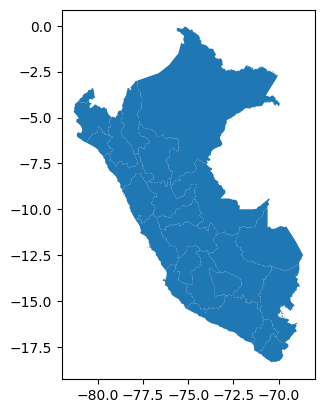

In [5]:
shp_Peru = gpd_read_file("/content/drive/MyDrive/PROGRAMACIÓN_2/DATA/shapefile/shapefiles_peru/Departamentos.shp")
shp_Peru.plot()

In [6]:
def xr_crop(shp_i, netcdf_i):

  # get box
  box_i = shp_i.total_bounds

  # crop based on box
  crop_netcdf_i = netcdf_i.where((netcdf_i["longitude"] > box_i[0]) & # min lon
                                 (netcdf_i["longitude"] < box_i[2]) & # max lon
                                 (netcdf_i["latitude"] > box_i[1]) & # min lat
                                 (netcdf_i["latitude"] < box_i[3]), # max lat
                                 drop = True)

  return crop_netcdf_i

def xr_shp_to_grid(shp_i, netcdf_array):

  # get real box
  shp_i_geometry = shp_i.geometry

  # adding crs
  mask = netcdf_array.rio.set_crs(shp_i.crs)

  # "rasterizing"
  mask = mask.rio.clip(shp_i_geometry, drop = False)

  # making "True/False" values
  mask.values[~np.isnan(mask.values)] = 1

  return mask.drop(["time", "spatial_ref"])


def xr_mask(grid_mask, netcdf_i):

  # masking
  mask_netcdf_i = netcdf_i.where(grid_mask == True)

  return mask_netcdf_i

In [7]:
shp_Peru

,DEPCOD,DEPNOM,geometry
0,01,AMAZONAS,"POLYGON ((-77.71584 -5.10859, -77.71561 -5.108..."
1,02,ANCASH,"POLYGON ((-77.43826 -8.41625, -77.43879 -8.419..."
2,03,APURIMAC,"POLYGON ((-73.51174 -13.38481, -73.50822 -13.3..."
3,04,AREQUIPA,"POLYGON ((-71.89395 -14.78905, -71.89342 -14.7..."
4,05,AYACUCHO,"POLYGON ((-73.74697 -13.75935, -73.74495 -13.7..."
5,06,CAJAMARCA,"POLYGON ((-78.68236 -7.39208, -78.68268 -7.392..."
6,07,CALLAO,"MULTIPOLYGON (((-77.22816 -12.06813, -77.22681..."
7,08,CUSCO,"POLYGON ((-70.86265 -13.80001, -70.86680 -13.8..."
8,09,HUANCAVELICA,"POLYGON ((-75.52429 -13.81763, -75.52566 -13.8..."
9,10,HUANUCO,"POLYGON ((-76.23089 -10.37179, -76.23136 -10.3..."


<Axes: >

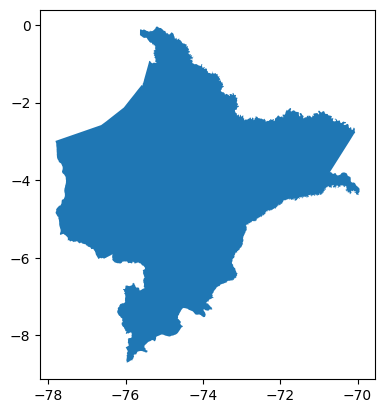

In [8]:
loreto = shp_Peru.iloc[[15]]
loreto.plot()

In [9]:
PISCOp = xr.open_dataset("/content/drive/MyDrive/PROGRAMACIÓN_2/DATA/data.nc")
PISCOp = PISCOp.rename({"X":"longitude","Y":"latitude","T":"time"})
PISCOp["time"] = pd.date_range(start="1981-01-01T12:00:00.000000000",freq="24H", periods= 13149)
PISCOp

<xarray.Dataset>
Dimensions:    (time: 13149, latitude: 198, longitude: 133)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
Data variables:
    Prec       (time, latitude, longitude) float32 ...

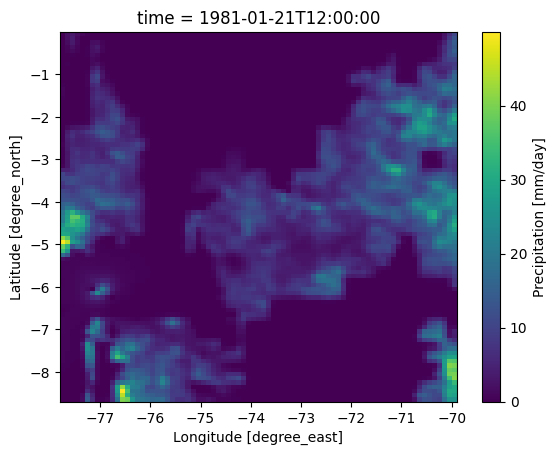

In [10]:
PISCOpp_crop = xr_crop(shp_i=loreto, netcdf_i=PISCOp)
PISCOpp_crop.Prec.isel(time=20).plot()

In [11]:
shp_exp_grid = xr_shp_to_grid(shp_i = loreto,
                              netcdf_array = PISCOpp_crop.Prec)


PISCOp_crop_masked = xr_mask(grid_mask = shp_exp_grid,
                             netcdf_i = PISCOpp_crop)

PISCOp_crop_masked

<xarray.Dataset>
Dimensions:    (time: 13149, latitude: 87, longitude: 79)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * latitude   (latitude) float32 -0.05 -0.15 -0.25 -0.35 ... -8.45 -8.55 -8.65
  * longitude  (longitude) float32 -77.75 -77.65 -77.55 ... -70.15 -70.05 -69.95
Data variables:
    Prec       (time, latitude, longitude) float32 nan nan nan ... nan nan nan

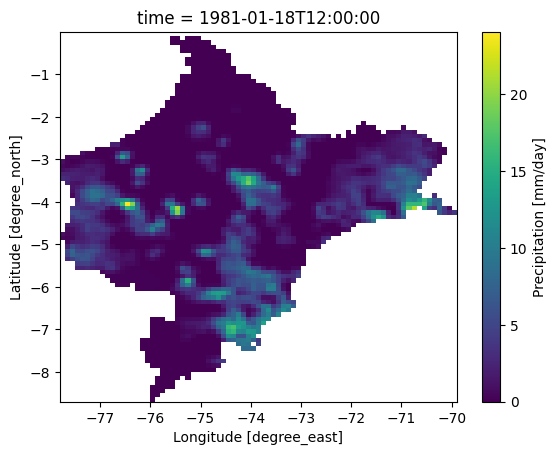

In [12]:
PISCOp_crop_masked.Prec.isel(time=17).plot()